In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tikzplotlib
import json
from collections import Counter

In [2]:
color0 = (0.12156862745098,0.466666666666667,0.705882352941177)
color1 = (1,0.498039215686275,0.0549019607843137)
colora0 = (0.823529411764706,0.8901960784313725,0.941176470588235)
colora1 = (1,0.8980392156862745,0.807843137254902)

In [3]:
def load_data(filename: str, columns: dict = {}):
    df = pd.read_csv(f"../data/{filename}.csv")
    df.rename(columns=columns, inplace=True)
    df['iteration'] = range(1, len(df)+1)
    return df

In [4]:
def plot_data(filename: str, legend: str):
    df = load_data(filename, columns={'score': legend})
    df['mode'] = legend
    sns.lineplot(x='runtime', y=legend, hue='mode', data=df, drawstyle='steps')

In [5]:
def load_multiple(data: dict):
    dfs = []
    for mode in data.keys():
        mode_id = 0
        filenames = data[mode]
        for filename in filenames:
            df = load_data(filename)
            df['mode'] = mode
            df['mode_id'] = mode_id
            dfs.append(df)
            mode_id += 1
    keys = [f"Run {i}" for i in range(len(dfs))]
    dfs = pd.concat(dfs, keys=keys)
    dfs = dfs.groupby(['mode', 'mode_id', 'score'], as_index=False).agg({'runtime': 'first', 'iteration': 'first'})
    return dfs

In [6]:
def ffill_dfs(dfs):
    runtimes = sorted(Counter(dfs['runtime']).keys())
    
    for group in dfs.groupby(['mode', 'mode_id']):
        df = group[1]
        df_id = df.iloc[0]['mode_id']
        df_mode = df.iloc[0]['mode']
        start = df.iloc[0]['runtime']
        end = df.iloc[-1]['runtime']
        rng = runtimes[runtimes.index(start):runtimes.index(end)]
        df_rt = list(df['runtime'])
        prev_value = 0
        
        for runtime in rng:
            if runtime in df_rt:
                idx = df_rt.index(runtime)
                prev_value = df.iloc[idx]['score']
            else:
                dfs = dfs.append({'mode_id': df_id, 'mode': df_mode, 'runtime': runtime, 'score': prev_value}, ignore_index=True)
    
    return dfs

In [7]:
def multi_step_chart(dfs):
    fig, ax = plt.subplots()
    sns.lineplot(x='runtime', y='score', hue='mode', style='mode_id', data=dfs, ax=ax, drawstyle='steps-post')
    plt.xscale('log')
    return (fig, ax)

In [8]:
def multi_sd_chart(dfs):
    dfs = ffill_dfs(dfs)

    fig, ax = plt.subplots()
    sns.lineplot(x='runtime', y='score', hue='mode', data=dfs, ax=ax, ci='sd', estimator='mean')
    plt.xscale('log')
    return (fig, ax)

In [9]:
base_path = '../../../rapport/plots/'

def tikzsave(name: str):
    tikzplotlib.save(base_path + name + '.tex')

# Stagnation plot (10s)

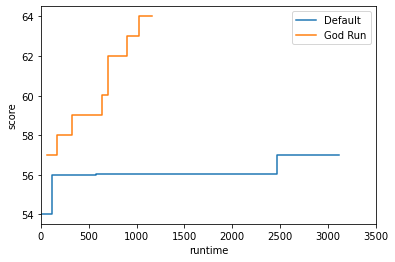

In [10]:
dfs = load_multiple({
    "Default": ["berlin_10s_standard"],
    "God run": ["berlin_10s_godrun"]
})

fig, ax = plt.subplots()
sns.lineplot(x='runtime', y='score', hue='mode', data=dfs, ax=ax, drawstyle='steps-post', legend=False)
plt.xlim(0, 3500)
plt.legend(['Default', 'God Run'])

tikzsave('stagnation_plot')

# Multithreading (God run)

In [11]:
dfs_gr = load_multiple({
    "MT": ["threading_godrun_1s", "threading_godrun_10s", "threading_godrun_30s", "threading_godrun_60s"],
    "ST": ["nothreading_godrun_1s", "nothreading_godrun_10s", "nothreading_godrun_30s", "nothreading_godrun_60s"]
})

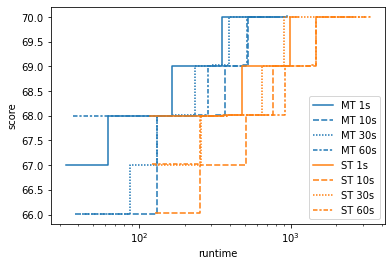

In [12]:
multi_step_chart(dfs_gr)
plt.legend(['MT 1s', 'MT 10s', 'MT 30s', 'MT 60s', 'ST 1s', 'ST 10s', 'ST 30s', 'ST 60s'], loc='lower right')
tikzsave('threading_godrun_step')

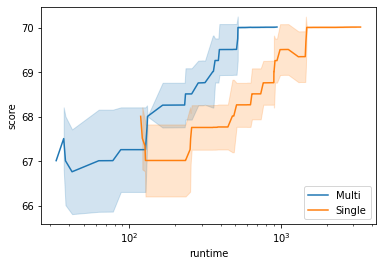

In [13]:
multi_sd_chart(dfs_gr)
plt.legend(['Multi', 'Single'], loc='lower right')
tikzsave('threading_godrun_sd')

# Multithreading (Default)

In [14]:
dfs_df = load_multiple({
    "MT": ["threading_default_1s", "threading_default_10s", "threading_default_30s", "threading_default_60s"],
    "ST": ["nothreading_default_1s", "nothreading_default_10s", "nothreading_default_30s", "nothreading_default_60s"]
})

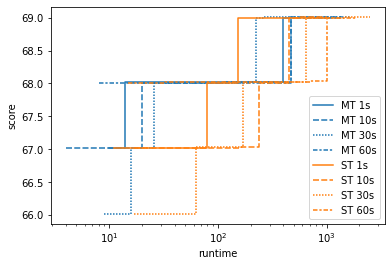

In [15]:
multi_step_chart(dfs_df)
plt.legend(['MT 1s', 'MT 10s', 'MT 30s', 'MT 60s', 'ST 1s', 'ST 10s', 'ST 30s', 'ST 60s'], loc='lower right')
tikzsave('threading_default_step')

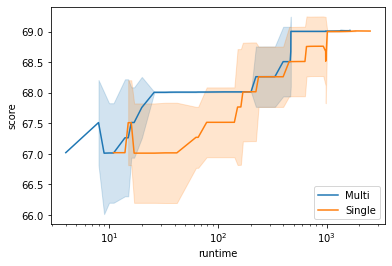

In [16]:
multi_sd_chart(dfs_df)
plt.legend(['Multi', 'Single'], loc='lower right')
tikzsave('threading_default_sd')

# Best-ant-limit

In [17]:
lines = []

with open("../data/traj.json", 'r') as infile:
    lines = infile.readlines()
    
def parse_line(line: str):
    data = json.loads(line)
    
    incumbent = data['incumbent']
    incumbent['wallclock_time'] = data['wallclock_time']
    incumbent['evaluations'] = data['evaluations']
    
    return incumbent
    
traj = pd.DataFrame([parse_line(line) for line in lines])

traj['evaporation'] = traj['evaporation'].mul(100).round(2)
traj['Evaluation'] = traj['evaluations'].cumsum()

traj

,alpha,beta,evaporation,f_antcount,g_bestant,wallclock_time,evaluations,Evaluation
0,1,1,1.00,50,0,0.000156,0,0
1,1,1,1.00,50,0,1.114998,1,1
2,24,68,94.92,384,6,611.859459,4,5
3,9,79,23.03,482,9,1831.258654,8,13
4,96,44,5.22,633,9,3355.794904,13,26
5,66,11,92.56,580,5,6099.663631,22,48
6,11,20,49.98,815,6,8539.304652,30,78
7,11,10,58.79,828,7,14944.060131,51,129
8,1,10,51.17,954,8,20129.480754,68,197
9,1,8,45.35,878,1,37217.381725,125,322


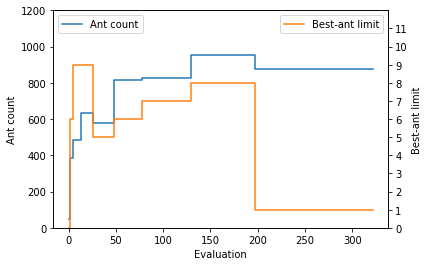

In [18]:
fig, ax = plt.subplots()
lns1 = sns.lineplot(x='Evaluation', y='f_antcount', data=traj, ax=ax, drawstyle='steps-pre', color=color0, label='Ant count', legend=False)
plt.ylabel('Ant count')
ax.set_ylim(0,1200)

ax2 = ax.twinx()
lns2 = sns.lineplot(x='Evaluation', y='g_bestant', data=traj, ax=ax2, drawstyle='steps-pre', color=color1, label='Best-ant limit', legend=False)
plt.ylabel('Best-ant limit')
ax2.set_ylim(0,12)
ax2.set_yticks([i for i in range(0,12)])

lns1.legend(loc='upper left')
lns2.legend(loc='upper right')

tikzsave('bestantlimit_plot')

Text(0, 0.5, 'Evaporation')

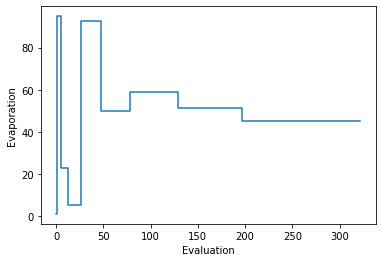

In [19]:
sns.lineplot(x='Evaluation', y='evaporation', data=traj, drawstyle='steps-pre', label='Evaporation', legend=False)
plt.ylabel('Evaporation')

# Randomness

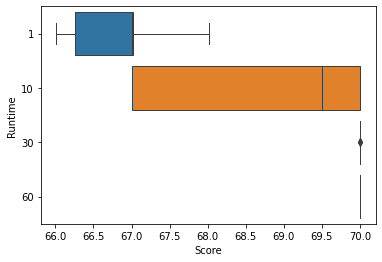

In [20]:
df = pd.read_csv(base_path + '../files/munchenaverage_individualized.csv')
df['points'] = [int(row['score']) + (1-int(row['cost'])/30000) for _, row in df.iterrows()]

sns.boxplot(x='points', y='time', data=df, orient='h', linewidth=1)
plt.ylabel('Runtime')
plt.xlabel('Score')
tikzsave('randomness_boxplot')

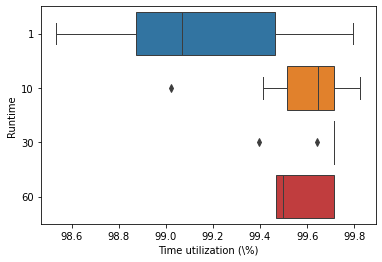

In [21]:
df['cost_ratio'] = df['cost'].div(30000).mul(100)

sns.boxplot(x='cost_ratio', y='time', data=df, orient='h', linewidth=1)
plt.ylabel('Runtime')
plt.xlabel('Time utilization (\\%)')
tikzsave('randomness_boxplot_cost')

In [22]:
df.filter(['time','points']).groupby('time').agg(['min','max','mean','std'])

points                                
            min        max       mean       std
time                                           
1     66.008533  68.013400  66.908573  0.737487
10    67.004200  70.004533  68.704247  1.492879
30    70.002867  70.006033  70.003253  0.001001
60    70.002867  70.005300  70.004270  0.001215